In [1]:
import cv2;
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d
%matplotlib inline

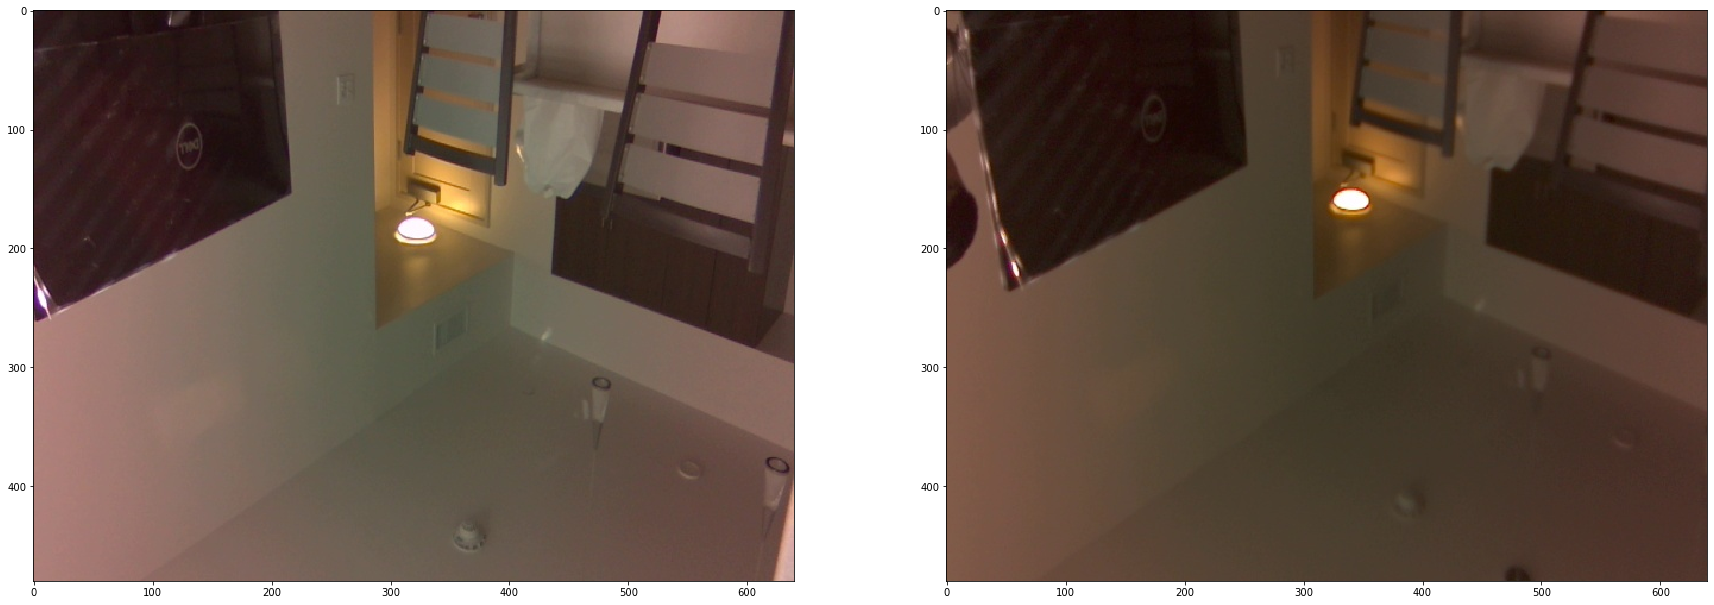

In [2]:
plt.figure(figsize=(30,30))
im1 = plt.imread('im1.jpg')
im2 = plt.imread('im2.jpg')
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

In [3]:
im1 = cv2.imread('im1.jpg')
im2 = cv2.imread('im2.jpg')
grayim1 = np.mean(im1,axis=2)
grayim1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
grayim2 = np.mean(im2,axis=2)
grayim2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

## This is the Stereo Code for Disparity Map

In [206]:
'''
    This is all of the block matching code. The rest of this is attempted triangulation.
'''



stereo_bm = cv2.StereoSGBM_create(minDisparity=0,
                                  numDisparities=32,
                                  blockSize=5,
                                  P1=3,
                                  disp12MaxDiff=50,
                                  uniquenessRatio=0,
                                  preFilterCap = 0,
                                  speckleWindowSize=0,
                                  speckleRange=0,
                                  mode=1)

#stereo_bm = cv2.StereoSGBM_create(0,32)
dispmap_bm = stereo_bm.compute(grayim1,grayim2) / 16.0

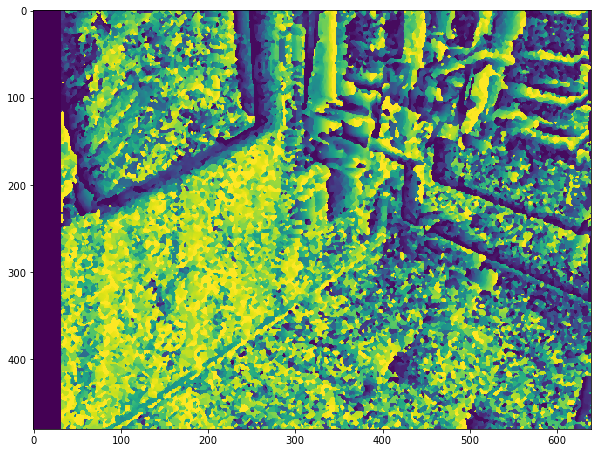

In [207]:
plt.figure(figsize=(10,10))
plt.imshow(dispmap_bm)

60mm -> baseline <br>
2.6mm -> focal length <br>
3.576mm x 2.760 mm sensor <br>

In [151]:
#creating focal length pixels
fcolpix = 2.6 * 640 / 3.576
frowpix = 2.6 * 480 / 2.76
favgpix = (fcolpix + frowpix)/2 # in pixels

In [152]:
#using meshgrid on the image to get the point clouds necessary
#in adition, using the disparity map 
# formula to get triangulated coords is ---> (x - cx) * baseline/disparity

xx,yy = np.meshgrid(np.arange(grayim1.shape[1]), np.arange(grayim1.shape[0]))
dp_flatten = dispmap_bm.flatten()
xx = xx.flatten()
yy = yy.flatten()
mask = (dp_flatten > 0) #masking only valid coordinates (near zero are occlusions)


pix_coords = np.vstack((xx,yy))
pix_valid = pix_coords[:,mask]

c = np.array([[grayim1.shape[1]/2, grayim1.shape[0]/2]]).T
baseline = 60
pix_transform = (pix_coords[:,mask] - c) * (baseline / (dp_flatten[mask]))
z_coords = (baseline * favgpix) / dp_flatten[mask]

x = pix_transform[0,:]
y = pix_transform[1,:]

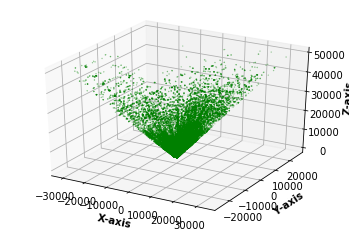

In [153]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x,y, z_coords,color='green', s=0.1)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

### Estimating Depth Map

/tmp/ipykernel_199330/2235582804.py:1: RuntimeWarning: divide by zero encountered in true_divide
  z_map = baseline * favgpix / dispmap_bm;


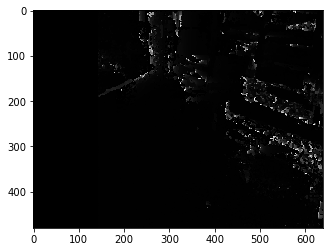

In [115]:
z_map = baseline * favgpix / dispmap_bm;
z_map[dispmap_bm <= 0] = 0
plt.imshow(z_map / z_map.max(), cmap='gray')

### testing output

In [295]:
colors = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
points_3D = np.vstack((x,y,z_coords))

output_points = points_3D.T
color_map = colors[mask.reshape(grayim1.shape), :].reshape(-1,3)

In [97]:
def create_output(vertices, colors, filename):
	vertices = np.hstack([vertices,colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [297]:
create_output(output_points, color_map, 'test.ply')